# data processing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Import data

In [8]:
import os
import datetime as dt

main_path = os.getcwd()


#load price (exchange rate) data
df_P = pd.read_pickle(main_path+'\\data\\future_price_bear.pkl')
df_P = df_P.fillna(method='ffill').drop(df_P.index[0])

#weekly return
df_r = pd.read_pickle(main_path+'\\data\\future_return_bear.pkl')
df_r = df_r.fillna(method='ffill').dropna()

df_r.shape

(284, 6)

## Kalman filter fucntion

In [4]:
import numpy as np
from pykalman import KalmanFilter

def fitKCA(t,z,q,fwd=0):
    '''
    Args:
        t: iterable with time indices
        z: iterable with measurements
        q: scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (default to 0)
    Returns:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    '''
    #monthly timestep
    h = (t[-1] - t[0])/t.shape[0]
    
    A = np.array([[1, h, 0.5*h**2],
                 [0, 1, h],
                 [0, 0, 1]])
    Q = q*np.eye(A.shape[0])

    #set up Kalman filter
    kf = KalmanFilter(transition_matrices=A, transition_covariance=Q)

    #EM for parameter esimtates
    kf = kf.em(z)

    #smooth
    x_mean, x_cov = kf.smooth(z)

    #forecast
    for fwd_ in range(fwd):
        x_mean_, x_cov_ = kf.filter_update(filtered_state_mean=x_mean[-1],
                                         filtered_state_covariance=x_cov[-1])
        x_mean = np.append(x_mean, x_mean_.reshape(1,-1), axis=0)
        x_cov_ = np.expand_dims(x_cov_, axis=0)
        x_cov = np.append(x_cov, x_cov_, axis=0)

    #std series
    x_std = (x_cov[:,0,0]**0.5).reshape(-1,1)
    for i in range(1, x_cov.shape[1]):
        x_std_ = x_cov[:,i,i]**0.5
        x_std = np.append(x_std, x_std_.reshape(-1,1), axis=1)
        
    return x_mean, x_std, x_cov

## Data visulization

In [9]:
# raw = pd.read_csv('C:/Users/janeg/cornell_projects/Opt_proj/DEXJPUS.csv')
# df = raw[raw['DATETIME'] >= '2000-05-01']
# df = df.set_index(pd.to_datetime(df['DATETIME'])).drop(columns=['DATETIME'])
# df_P = df_P.drop(columns='YM')
# df_r = df_r.drop(columns='YM')

t_date = df_P.index
t = np.array(range(len(t_date)))
z = np.array(df_P)
z_r = np.array(df_r)
title = df_P.columns


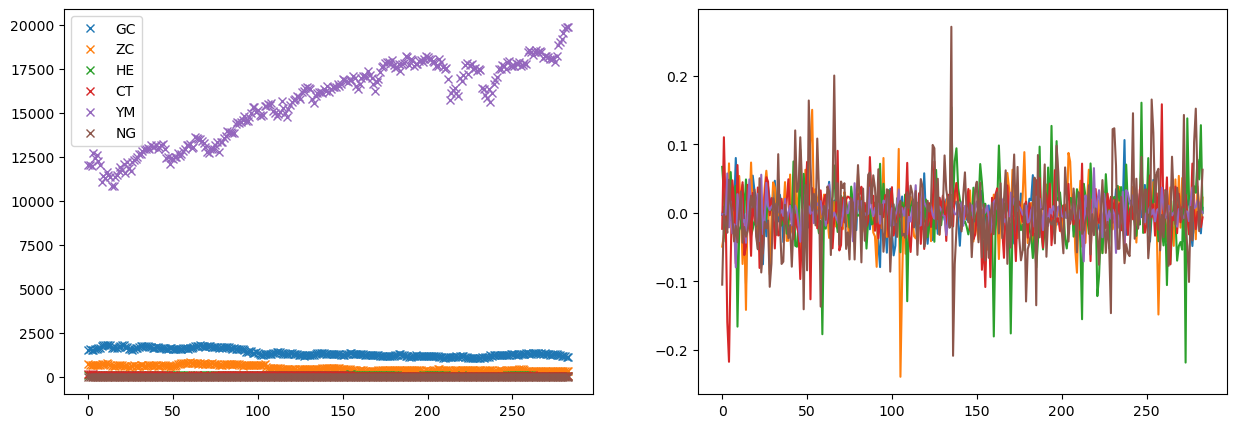

[0.02423703 0.03857575 0.04722536 0.03856969 0.01862797 0.05806438]


In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.plot(t,z,marker='x',linestyle='', label=df_r.columns)
ax1.legend()
# ax1.set_title(title+' (Price)')
ax2.plot(t,z_r,linestyle='-', label=df_r.columns)
# ax2.set_title(title+' (log return)')
plt.show()
print(np.std(z_r, axis=0))

In [1]:
print(z.shape)
print(t.shape)

NameError: name 'z' is not defined

## DEMO of KCA using only 1 risky asset

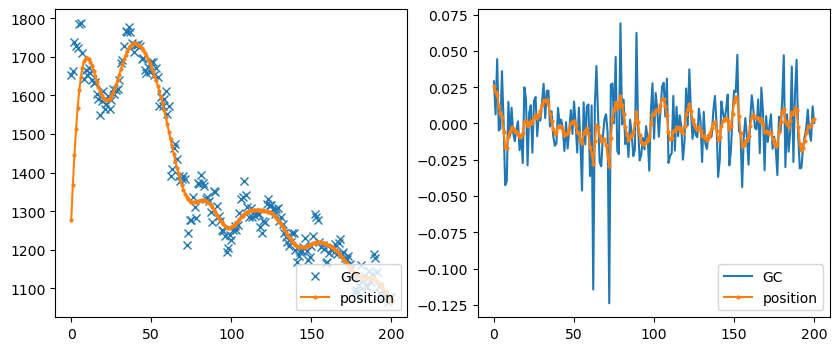

In [7]:
#smoothing result
z_test = z[:,0]
z_r_test = z_r[:,0]

for q in [1e-4]:
    x_point, x_bands, x_cov = fitKCA(t, z_test, q=q, fwd=0)
    xr_point, xr_bands, xr_cov = fitKCA(t, z_r_test, q=q, fwd=0)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
    ax1.plot(t, z_test, marker='x', linestyle='',label='GC')
    ax1.plot(t, x_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
    ax1.legend(loc="lower right")

    ax2.plot(t, z_r_test, linestyle='-',label='GC')
    ax2.plot(t, xr_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
    ax2.legend(loc="lower right")
    plt.show()

In [ ]:
mean_accel_P = x_point[:,2].mean()
mean_accel_r = xr_point[:,2].mean()
print(f"mean accelartion: P = {mean_accel_P:.6f}, r = {mean_accel_r:.6f}")

std_accel_P = x_point[:,2].std()
std_accel_r = xr_point[:,2].std()
print(f"std accelartion: P = {std_accel_P:.6f}, r = {std_accel_r:.6f}")


mean accelartion: P = -0.035778, r = -0.000021
std accelartion: P = 0.612164, r = 0.000459


### Paper code replication (KCA-specific)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def getPeriodic(periods, nobs, scale, seed=0):
    t = np.linspace(0, np.pi*periods/2., nobs)
    rnd = np.random.RandomState(seed)
    signal = np.sin(t)
    z = signal + scale * rnd.randn(nobs)
    return t, signal, z

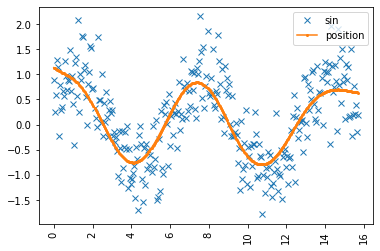

In [ ]:
nobs, periods = 300, 10
t, signal, z = getPeriodic(periods, nobs, scale=0.5)
x_point, x_bands = fitKCA(t, z, q=1e-4)[:2]

plt.plot(t, z, marker='x', linestyle='',label='sin')
plt.plot(t, x_point[:,0], marker='o', linestyle='-', markersize=2, label='position')
plt.legend(loc="upper right")
plt.xticks(rotation=90)
plt.show()